In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.makedirs('people', exist_ok=True)
os.makedirs('people/images', exist_ok=True)
os.makedirs('people/masks', exist_ok=True)

In [3]:
input_root = '/kaggle/input/samsung-2024-cv/data/photos_people'
data_work = '/kaggle/working'
root_path = '/kaggle/working/people'
data_root_images = '/kaggle/working/people/images'
data_root_masks = '/kaggle/working/people/masks'

In [4]:
for dirname, _, filenames in os.walk(input_root):
    for filename in filenames:
        if dirname == f'{input_root}/images':
            shutil.copy(os.path.join(dirname, filename), os.path.join(data_root_images,filename))
        if dirname == f'{input_root}/masks':
            shutil.copy(os.path.join(dirname, filename), os.path.join(data_root_masks,filename))
            
print(len(os.listdir(data_root_images)), len(os.listdir(data_root_masks)))

2667 2667


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import albumentations as A
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8f2ca5f0a4de6b451b66b156ce9cf0c1872e84d1f04e99dd2946fea4bd9f3d2d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=94913727a13a99f36e1c96f54054e5f767a1be5c84f67fd73377dcd0d00ba1f4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [6]:
df = pd.read_csv(f"{input_root}/df.csv")
print(f'Total number of pictures: {len(df)}')
# get 2400 images (150 batches * 16 batch_size)
df = df.sample(2400)
df.reset_index(drop=True, inplace=True)
df.head()

Total number of pictures: 2667


,Unnamed: 0,images,masks,collages
0,1385,images/ds6_pexels-photo-724502.png,masks/ds6_pexels-photo-724502.png,collage/ds6_pexels-photo-724502.jpg
1,285,images/ds1_pexels-photo-576801.png,masks/ds1_pexels-photo-576801.png,collage/ds1_pexels-photo-576801.jpg
2,1805,images/ds8_adult-attractive-full-body-41215.png,masks/ds8_adult-attractive-full-body-41215.png,collage/ds8_adult-attractive-full-body-41215.jpg
3,202,images/ds1_pexels-photo-247295.png,masks/ds1_pexels-photo-247295.png,collage/ds1_pexels-photo-247295.jpg
4,2442,images/ds8_pexels-photo-803985.png,masks/ds8_pexels-photo-803985.png,collage/ds8_pexels-photo-803985.jpg


In [7]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-10,10), p=0.5),
])

val_transforms = A.Compose([
    A.Resize(512, 512),
])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_dataset = MyDataset(train_df, root_path, transforms_=train_transforms)
val_dataset = MyDataset(val_df, root_path, transforms_=val_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 1920
len val: 480


In [9]:
model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet", 
    in_channels=3,              
    classes=1,                
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [10]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.train() # training mode
    epoch_loss = 0
    epoch_iou_score = 0
    
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        
        lr_scheduler.step()
        
    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch


def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval() # evaluation mode
    epoch_loss = 0
    epoch_iou_score = 0
    
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)

            pred = model(x)
            loss = loss_fn(pred, y)
            
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
            
    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch

In [11]:
epochs = 30

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
    
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = val(val_loader, model, loss_fn)

    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    torch.save(model.state_dict(), "checkpoints/last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
        
    if counter >= patience:
        print("Earlystop!")
        break

  3%|▎         | 1/30 [03:27<1:40:10, 207.27s/it]

EPOCH: 001     train_loss: 0.1971, val_loss: 0.1375     train_iou_score: 0.740, val_iou_score: 0.777     lr: 0.001


  7%|▋         | 2/30 [06:52<1:36:10, 206.09s/it]

EPOCH: 002     train_loss: 0.1131, val_loss: 0.1085     train_iou_score: 0.807, val_iou_score: 0.812     lr: 0.001


 10%|█         | 3/30 [10:17<1:32:26, 205.44s/it]

EPOCH: 003     train_loss: 0.0930, val_loss: 0.0842     train_iou_score: 0.835, val_iou_score: 0.850     lr: 0.001


 13%|█▎        | 4/30 [13:42<1:28:55, 205.22s/it]

EPOCH: 004     train_loss: 0.0893, val_loss: 0.0836     train_iou_score: 0.839, val_iou_score: 0.849     lr: 0.001


 17%|█▋        | 5/30 [17:06<1:25:26, 205.06s/it]

EPOCH: 005     train_loss: 0.0843, val_loss: 0.0827     train_iou_score: 0.847, val_iou_score: 0.850     lr: 0.001


 20%|██        | 6/30 [20:34<1:22:19, 205.83s/it]

EPOCH: 006     train_loss: 0.0810, val_loss: 0.0833     train_iou_score: 0.853, val_iou_score: 0.849     lr: 0.001


 23%|██▎       | 7/30 [23:59<1:18:51, 205.73s/it]

EPOCH: 007     train_loss: 0.0728, val_loss: 0.0787     train_iou_score: 0.866, val_iou_score: 0.856     lr: 0.001


 27%|██▋       | 8/30 [27:26<1:15:30, 205.92s/it]

EPOCH: 008     train_loss: 0.0768, val_loss: 0.0734     train_iou_score: 0.859, val_iou_score: 0.865     lr: 0.001


 30%|███       | 9/30 [30:50<1:11:53, 205.40s/it]

EPOCH: 009     train_loss: 0.0623, val_loss: 0.0609     train_iou_score: 0.884, val_iou_score: 0.887     lr: 0.0001


 33%|███▎      | 10/30 [34:14<1:08:22, 205.11s/it]

EPOCH: 010     train_loss: 0.0530, val_loss: 0.0573     train_iou_score: 0.901, val_iou_score: 0.893     lr: 0.0001


 37%|███▋      | 11/30 [37:39<1:04:56, 205.06s/it]

EPOCH: 011     train_loss: 0.0484, val_loss: 0.0551     train_iou_score: 0.909, val_iou_score: 0.897     lr: 0.0001


 40%|████      | 12/30 [41:04<1:01:28, 204.94s/it]

EPOCH: 012     train_loss: 0.0463, val_loss: 0.0515     train_iou_score: 0.913, val_iou_score: 0.903     lr: 0.0001


 43%|████▎     | 13/30 [44:29<58:02, 204.88s/it]  

EPOCH: 013     train_loss: 0.0426, val_loss: 0.0508     train_iou_score: 0.919, val_iou_score: 0.905     lr: 0.0001


 47%|████▋     | 14/30 [47:53<54:37, 204.83s/it]

EPOCH: 014     train_loss: 0.0423, val_loss: 0.0510     train_iou_score: 0.920, val_iou_score: 0.904     lr: 0.0001


 50%|█████     | 15/30 [51:18<51:12, 204.80s/it]

EPOCH: 015     train_loss: 0.0397, val_loss: 0.0496     train_iou_score: 0.925, val_iou_score: 0.907     lr: 0.0001


 53%|█████▎    | 16/30 [54:43<47:46, 204.79s/it]

EPOCH: 016     train_loss: 0.0394, val_loss: 0.0479     train_iou_score: 0.925, val_iou_score: 0.910     lr: 0.0001


 57%|█████▋    | 17/30 [58:09<44:26, 205.10s/it]

EPOCH: 017     train_loss: 0.0382, val_loss: 0.0478     train_iou_score: 0.927, val_iou_score: 0.910     lr: 1e-05


 60%|██████    | 18/30 [1:01:34<41:00, 205.04s/it]

EPOCH: 018     train_loss: 0.0360, val_loss: 0.0475     train_iou_score: 0.931, val_iou_score: 0.911     lr: 1e-05


 63%|██████▎   | 19/30 [1:04:57<37:31, 204.67s/it]

EPOCH: 019     train_loss: 0.0357, val_loss: 0.0479     train_iou_score: 0.932, val_iou_score: 0.910     lr: 1e-05


 67%|██████▋   | 20/30 [1:08:21<34:04, 204.42s/it]

EPOCH: 020     train_loss: 0.0355, val_loss: 0.0478     train_iou_score: 0.932, val_iou_score: 0.910     lr: 1e-05


 70%|███████   | 21/30 [1:11:45<30:38, 204.24s/it]

EPOCH: 021     train_loss: 0.0351, val_loss: 0.0475     train_iou_score: 0.933, val_iou_score: 0.911     lr: 1e-05


 73%|███████▎  | 22/30 [1:15:09<27:14, 204.27s/it]

EPOCH: 022     train_loss: 0.0346, val_loss: 0.0475     train_iou_score: 0.934, val_iou_score: 0.911     lr: 1e-05


 77%|███████▋  | 23/30 [1:18:34<23:50, 204.35s/it]

EPOCH: 023     train_loss: 0.0342, val_loss: 0.0472     train_iou_score: 0.935, val_iou_score: 0.911     lr: 1e-05


 80%|████████  | 24/30 [1:21:58<20:26, 204.40s/it]

EPOCH: 024     train_loss: 0.0342, val_loss: 0.0472     train_iou_score: 0.935, val_iou_score: 0.911     lr: 1e-05


 83%|████████▎ | 25/30 [1:25:23<17:01, 204.37s/it]

EPOCH: 025     train_loss: 0.0348, val_loss: 0.0473     train_iou_score: 0.934, val_iou_score: 0.911     lr: 1.0000000000000002e-06


 87%|████████▋ | 26/30 [1:28:46<13:36, 204.02s/it]

EPOCH: 026     train_loss: 0.0334, val_loss: 0.0468     train_iou_score: 0.936, val_iou_score: 0.912     lr: 1.0000000000000002e-06


 90%|█████████ | 27/30 [1:32:10<10:11, 204.00s/it]

EPOCH: 027     train_loss: 0.0335, val_loss: 0.0472     train_iou_score: 0.936, val_iou_score: 0.911     lr: 1.0000000000000002e-06


 93%|█████████▎| 28/30 [1:35:33<06:47, 203.83s/it]

EPOCH: 028     train_loss: 0.0335, val_loss: 0.0468     train_iou_score: 0.936, val_iou_score: 0.912     lr: 1.0000000000000002e-06


 97%|█████████▋| 29/30 [1:38:57<03:23, 203.73s/it]

EPOCH: 029     train_loss: 0.0339, val_loss: 0.0473     train_iou_score: 0.935, val_iou_score: 0.911     lr: 1.0000000000000002e-06


100%|██████████| 30/30 [1:42:20<00:00, 204.70s/it]

EPOCH: 030     train_loss: 0.0341, val_loss: 0.0470     train_iou_score: 0.935, val_iou_score: 0.911     lr: 1.0000000000000002e-06


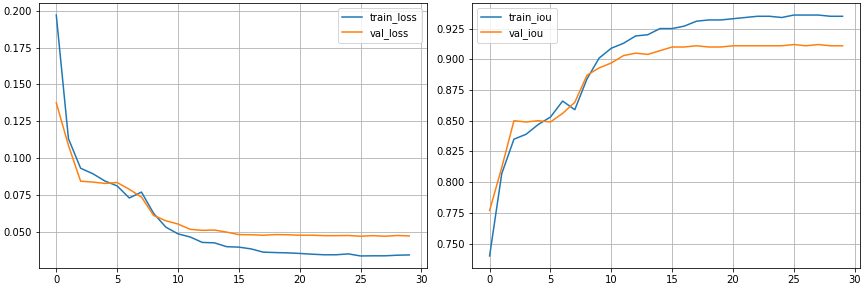

In [12]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir(f'{data_work}/')
    zip_name = f"{data_work}/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [13]:
download_file(f'{data_work}/checkpoints/best.pth', 'people_mobilenet_weigths')

/kaggle/working/people_mobilenet_weigths.zip

In [14]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(val_df, root_path, transforms_=val_transforms)

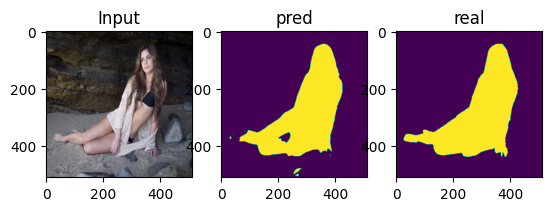

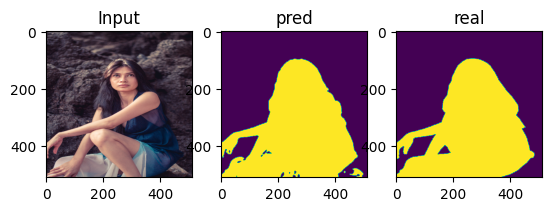

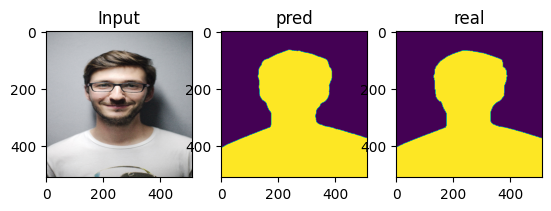

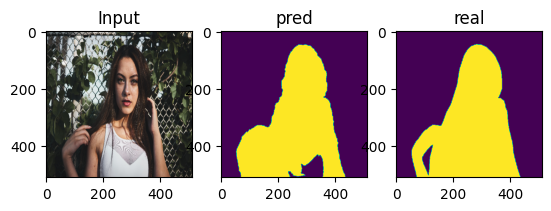

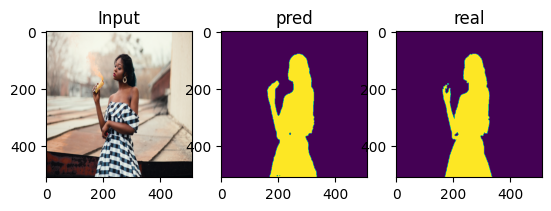

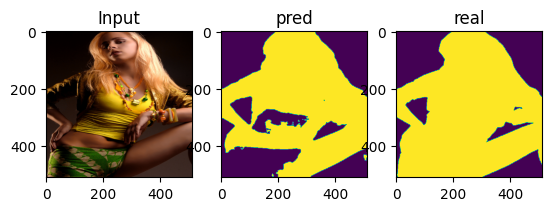

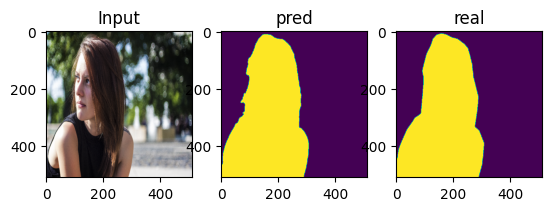

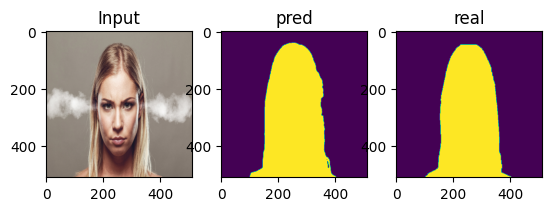

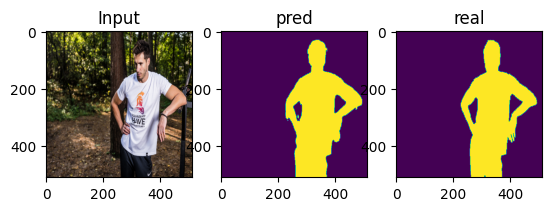

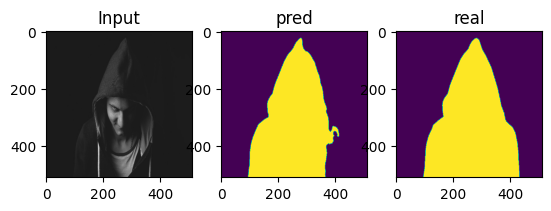

In [15]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 10
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('real')
    plt.show()